# This notebook 
## 1) reads and processes .mat files from Graf 2011
## 2) computes spike counts per trial
## 3) plots tuning curves
## 4) builds a Poisson Independent Decoder (PID)
## 5) builds an L1 regularized multinomial logistic regression model
## 6) builds a Bayesian hierarchical logistic regression model (many variations) 
## 7) evaluates the three models

In [1]:
#!/usr/bin/env python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [353]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn import *
from edward.models import Poisson, Categorical, Empirical, Laplace,Bernoulli, Multinomial, Normal, PointMass, MultivariateNormalDiag, MultivariateNormalFullCovariance, MultivariateNormalTriL

In [3]:
tf.__version__

'1.2.1'

In [4]:
ed.set_seed(42)
sess = ed.get_session()

In [5]:
def read_data(file_path):
    '''Read and process mat file from Graf2011
    
    param array_number: {1, 2, 3, 4, 5}

    return:
        spike_times: {Nx3600} N simultaneously recorded spike trains for 3600 trials
            (50 repeated trials of 72 direction in random order)
        orientation_per_trial: orientation for each trial (of length 3600)
        num_neurons: number of neurons
        orientations: sorted set of orientations
        num_repeats: number of repeats for each (orientation,neuron) (=50)
        num_trials: 50 repeated trials x 72 directions
        trial_length: length of trial (in seconds)
    '''
    dataStruct = scipy.io.loadmat(file_path)
    spike_times = pd.DataFrame.from_dict(dataStruct['spk_times'])
    orientation_per_trial = dataStruct['ori'][0]
    num_neurons = np.shape(dataStruct['neur_param'])[0]
    orientations = np.sort(np.unique(dataStruct['ori']))
    trial_length = 2560e-3
    num_repeats = 50
    num_trials = 3600 # 50 repeated trials x 72 directions
    num_orientations = len(orientations)
    return spike_times, orientation_per_trial, num_neurons, orientations, trial_length, num_repeats, num_trials, num_orientations

In [6]:
def compute_spike_counts(spike_times, num_neurons, num_trials):
    '''
        Compute spike counts for each (orientation, neuron, trial)
        return 3D numpy array: orientation x trials x neurons
        
        TODO: add option to average [0 180] with responses from [180 360]
    '''
    spike_times_mat = spike_times.as_matrix()
    spike_counts = np.zeros((num_orientations, num_neurons, num_repeats))
    # for each orientation
    for i in range(num_orientations):
        # access indices in spike times that corresponds to ori
        idx = np.where(orientation_per_trial == orientations[i])[0]
        spike_times_ori = np.take(spike_times_mat, idx, axis = 1)
        for j in range(num_neurons):
            for k in range(num_repeats):
                spike_counts[i, j, k] = np.count_nonzero(spike_times_ori[j][k])
    return spike_counts

In [7]:
'''
Filters to data
1) spike counts observed after 1280 ms
    - exclude
    - use to filter neurons that do not have a significantly higher mean tc with stimulus than without

2) from paper, 
To get visually driven neurons, we only accepted neurons of which the
peak or trough of their tuning curve fell outside of the window defined
by the mean and one s.d. of their spontaneous activity. Furthermore, we
obtained meaningful sample of V1 neurons by only considering neurons with
tuning curves that could be well approximated (r2   0.75) by bimodal
circular Gaussian functions (the sum of two von Mises functions with
different preferred orientations, amplitudes and bandwidths), allowing us
to accommo- date for direction (mono-modal) or orientation (bi-modal)
tuning. We obtained populations of simultaneously recorded neurons of
sizes 40, 57, 60, 70 and 74. Each data set was obtained in a ~3-h-long
recording session.

3) average across 180 degree axis?

4) if max of tc for neuron i across orientations - min of tc for neuron i across orientations is 
    not greater than 10, -> exclude neuron
    
5) divisive normalization

'''

def normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats):
    '''
        Normalize by variance of spike counts
            for each trial
                square spike counts across (neurons, orientations) then sum across neurons
                divide the square of each spike count by the summed squared spike counts across neurons
                
        PROBLEM: mean tuning curve gives same mean for all entries
    '''
    spike_counts_norm = np.zeros((num_orientations, num_neurons, num_repeats))
    for i in range(num_repeats):
        variance_sum = np.sum(spike_counts[:, :, i]**2, axis = 1).reshape(-1,1)
        spike_counts_norm[:, :, i] = (spike_counts[:, :, i]**2) / np.tile(variance_sum, num_neurons)
    return spike_counts_norm

In [8]:
best fit to the tuning curve 

one von mise might get too narrow - add a constraint to keep the means separate and prevent variances from going to 0

SyntaxError: invalid syntax (<ipython-input-8-a54a9182e0ea>, line 1)

From Graf 2011, "Evoked activity was estimated over the full stimulus presentation. We neglected the contamination by the blank preceding each grating because this period of the response (the first ~60 ms corresponding to typical V1 response latencies50) was of negligible duration compared with the 1,280 ms stimulus presentation time and this contamination was the same for each grating. Spontaneous activity was assessed on the last 500 ms of each blank presentation to avoid contamina- tion induced by the preceding grating. To get visually driven neurons, we only accepted neurons of which the peak or trough of their tuning curve fell outside of the window defined by the mean and one s.d. of their spontaneous activity. Furthermore, we obtained meaningful sample of V1 neurons by only considering neurons with tuning curves that could be well approximated (r2   0.75) by bimodal circular Gaussian functions (the sum of two von Mises functions with different preferred orientations, amplitudes and bandwidths), allowing us to accommo- date for direction (mono-modal) or orientation (bi-modal) tuning."



From Montijn 2014, "To further parameterize neuronal orientation tuning, we also calculated each neuron's preferred direction by fitting a double von Mises distribution to the neuron's responses, where the peaks of both von Mises functions are opposite to each other (separated by 180°):

$$f(x∣∣θ,κ1,κ2,μ0)= \frac{e^{κ_1cos(x−θ)}}{2πI_0(κ_1)} + \frac{e^{κ_2cos(x+π−θ)}}{2πI_0(κ_2)}+μ_0$$
(1)
Here, I0(κ) is the modified Bessel function of order 0 and x represents the stimulus angle. As can be seen in the equation, we defined the free parameters as θ (preferred direction), κ1 (concentration parameter at θ), κ2 (concentration parameter at θ +π) and μ0 (baseline response). A neuron's preferred direction was defined as the angle with the highest concentration parameter (which could be either κ1 or κ2)."

## is this based on training data or all?

In [9]:
def compute_mean_tc(spike_counts):
    return np.mean(spike_counts, axis=2)

def compute_var_tc(spike_counts):
    return np.var(spike_counts, axis=2)

def compute_cov_tc(spike_counts):
    tc_cov = np.zeros((num_neurons, num_neurons, num_orientations))
    for i in range(num_orientations):
        tc_cov[:, :, i] = np.cov(spike_counts[i])
    return tc_cov

In [10]:
def compute_preferred_orientation(mean_tc, num_neurons):
    '''max of tuning curve across orientations'''
    pref_ori = np.zeros(147)
    for i in range(num_neurons):
        pref_ori[i] = np.argmax(mean_tc[:,i])
    return pref_ori

In [11]:
plt.plot(pref_ori)

NameError: name 'pref_ori' is not defined

In [12]:
def filter_to_well_tuned_neurons(mean_tc, thresh):
    '''Filter to well tuned neurons, example thresh = 10'''
    maxdiff = np.max(mean_tc, axis=0) - np.min(mean_tc, axis=0)
    ind_tuned = np.where(maxdiff > thresh)[0]
    return ind_tuned

## y  ~ Poisson(f(x; $\theta$)), where f is a mixture of von mises, y is spike trains and x is orientation

In [1115]:
from scipy.special import i0 # 1st order bessel function

def mixture_von_mises(params):
    #from scipy.special import i0 # 1st order bessel function
    #k1, k2, mu1, mu2, weight = params
    
    k1, mu1 = params
    x = (np.arange(-36,36) / 72.0) * 2.0 * np.pi
    return (np.exp(k1 * np.cos(x - mu1))) / (2 * np.pi) * np.i0(k1)
    
    #first_term = weight * (np.exp(k1 * np.cos(x - mu1)) / (2 * np.pi) * np.i0(k1))
    
    #second_term = (1.0 - weight) * (np.exp(k1 * np.cos(x - mu1)) / (2 * np.pi) * np.i0(k2))
    #return np.array(first_term + second_term)

def poisson_distribution(y, rate):
    ll = (-y.shape[1] * rate).reshape(-1,1) + np.sum((y * np.log(rate).reshape(-1,1,1)), axis=1)
    return -np.sum(ll)

def f(params):
    y = x_train
    rate = mixture_von_mises(params)
    return poisson_distribution(y, rate)

In [1116]:
f([10.0, 1.0])

209844333973.12897

In [902]:
params = np.array([1.1, 2.0, 1.0, 3.0, .5])
#params = np.array([5.0,2.1])
scipy.optimize.minimize(f, params, method="L-BFGS-B", constraints=)
#scipy.optimize.fmin_bfgs(f, params)

      fun: -6970047.0952308103
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.18626451,  1.02445483, -0.09313226,  0.        , -0.37252903])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 18
   status: 0
  success: True
        x: array([ 0.05226898,  5.20792434,  1.12024674,  3.        , -3.04525624])

In [781]:
params = [1.0, 2.0, 1.0, 3.0, .5]
rate = mixture_von_mises(params)
y = x_train
poisson_distribution(y, rate)

array([[ -558.26817022,  -287.42746222,  -435.48704926, ...,
        -2293.45430613, -2573.32303773,  -321.7339519 ],
       [-1341.70136864,  -917.52474047,  -467.071684  , ...,
        -2642.38456919, -2950.19415778,  -166.76964636],
       [-1487.91485756, -1326.60301155,  -566.68817071, ...,
        -2869.75488784, -3159.33880417,  -300.42644898],
       ..., 
       [ -159.5182584 ,   -37.10461781,  -567.56372704, ...,
        -1071.34294024, -1506.0683049 ,  -839.07090424],
       [ -244.49697573,   -79.36933464,  -535.12162403, ...,
        -1089.95049808, -1727.34319266,  -799.32584977],
       [ -295.14866966,   -84.06308895,  -535.64781489, ...,
        -1608.37781519, -2181.07721858,  -703.47815364]])

In [538]:

def mixture_von_mises(x, k1, k2, mu1, mu2, weight):
    from scipy.special import i0 # 1st order bessel function

    first_term = weight * (np.exp(k1 * np.cos(x - mu1)) / (2 * np.pi) * np.i0(k1))
    second_term = (1.0 - weight) * (np.exp(k1 * np.cos(x - mu1)) / (2 * np.pi) * np.i0(k1))
    return first_term + second_term

In [443]:
import autograd.numpy as np
from autograd import grad

In [539]:
x_train.shape

(72, 35, 66)

In [ ]:
from numpy.core import linspace, atleast_1d, atleast_2d
from numpy.core.numeric import empty_like
def i0(x):
    """
    Modified Bessel function of the first kind, order 0.
    Usually denoted :math:`I_0`.  This function does broadcast, but will *not*
    "up-cast" int dtype arguments unless accompanied by at least one float or
    complex dtype argument (see Raises below).
    Parameters
    ----------
    x : array_like, dtype float or complex
        Argument of the Bessel function.
    Returns
    -------
    out : ndarray, shape = x.shape, dtype = x.dtype
        The modified Bessel function evaluated at each of the elements of `x`.
    Raises
    ------
    TypeError: array cannot be safely cast to required type
        If argument consists exclusively of int dtypes.
    See Also
    --------
    scipy.special.iv, scipy.special.ive
    Notes
    -----
    We use the algorithm published by Clenshaw [1]_ and referenced by
    Abramowitz and Stegun [2]_, for which the function domain is
    partitioned into the two intervals [0,8] and (8,inf), and Chebyshev
    polynomial expansions are employed in each interval. Relative error on
    the domain [0,30] using IEEE arithmetic is documented [3]_ as having a
    peak of 5.8e-16 with an rms of 1.4e-16 (n = 30000).
    References
    ----------
    .. [1] C. W. Clenshaw, "Chebyshev series for mathematical functions", in
           *National Physical Laboratory Mathematical Tables*, vol. 5, London:
           Her Majesty's Stationery Office, 1962.
    .. [2] M. Abramowitz and I. A. Stegun, *Handbook of Mathematical
           Functions*, 10th printing, New York: Dover, 1964, pp. 379.
           http://www.math.sfu.ca/~cbm/aands/page_379.htm
    .. [3] http://kobesearch.cpan.org/htdocs/Math-Cephes/Math/Cephes.html
    Examples
    --------
    >>> np.i0([0.])
    array(1.0)
    >>> np.i0([0., 1. + 2j])
    array([ 1.00000000+0.j        ,  0.18785373+0.64616944j])
    """
    x = atleast_1d(x).copy()
    y = empty_like(x)
    ind = (x < 0)
    x[ind] = -x[ind]
    ind = (x <= 8.0)
    y[ind] = _i0_1(x[ind])
    ind2 = ~ind
    y[ind2] = _i0_2(x[ind2])
    return y.squeeze()

def _i0_1(x):
    import autograd.numpy as np
    return np.exp(x) * _chbevl(x/2.0-2, _i0A)

def _chbevl(x, vals):
    b0 = vals[0]
    b1 = 0.0

    for i in range(1, len(vals)):
        b2 = b1
        b1 = b0
        b0 = x*b1 - b2 + vals[i]

    return 0.5*(b0 - b2)

def _i0_2(x):
    import autograd.numpy as np
    return np.exp(x) * _chbevl(32.0/x - 2.0, _i0B) / np.sqrt(x)

_i0A = [
    -4.41534164647933937950E-18,
    3.33079451882223809783E-17,
    -2.43127984654795469359E-16,
    1.71539128555513303061E-15,
    -1.16853328779934516808E-14,
    7.67618549860493561688E-14,
    -4.85644678311192946090E-13,
    2.95505266312963983461E-12,
    -1.72682629144155570723E-11,
    9.67580903537323691224E-11,
    -5.18979560163526290666E-10,
    2.65982372468238665035E-9,
    -1.30002500998624804212E-8,
    6.04699502254191894932E-8,
    -2.67079385394061173391E-7,
    1.11738753912010371815E-6,
    -4.41673835845875056359E-6,
    1.64484480707288970893E-5,
    -5.75419501008210370398E-5,
    1.88502885095841655729E-4,
    -5.76375574538582365885E-4,
    1.63947561694133579842E-3,
    -4.32430999505057594430E-3,
    1.05464603945949983183E-2,
    -2.37374148058994688156E-2,
    4.93052842396707084878E-2,
    -9.49010970480476444210E-2,
    1.71620901522208775349E-1,
    -3.04682672343198398683E-1,
    6.76795274409476084995E-1
    ]

_i0B = [
    -7.23318048787475395456E-18,
    -4.83050448594418207126E-18,
    4.46562142029675999901E-17,
    3.46122286769746109310E-17,
    -2.82762398051658348494E-16,
    -3.42548561967721913462E-16,
    1.77256013305652638360E-15,
    3.81168066935262242075E-15,
    -9.55484669882830764870E-15,
    -4.15056934728722208663E-14,
    1.54008621752140982691E-14,
    3.85277838274214270114E-13,
    7.18012445138366623367E-13,
    -1.79417853150680611778E-12,
    -1.32158118404477131188E-11,
    -3.14991652796324136454E-11,
    1.18891471078464383424E-11,
    4.94060238822496958910E-10,
    3.39623202570838634515E-9,
    2.26666899049817806459E-8,
    2.04891858946906374183E-7,
    2.89137052083475648297E-6,
    6.88975834691682398426E-5,
    3.36911647825569408990E-3,
    8.04490411014108831608E-1
    ]

In [507]:
np.i0(10.0)

array(2815.716628466254)

In [541]:
# x is orientations from -pi to pi
x = (np.arange(-36,36) / 72.0) * 2.0 * np.pi
r = x_train
k1 = 1.0
k2 = 1.0
mu1 = 1.0
mu2 = 5.0
weight = .4
f = mixture_von_mises_opt(k1, k2, mu1, mu2, weight)

In [461]:
r[:,0,0].shape

(72,)

In [468]:
vonmisesgrad = grad(np.log(f**r[:,0,0]))

In [1238]:
from numpy.core import linspace, atleast_1d, atleast_2d
from numpy.core.numeric import empty_like
def i0(x):
    """
    Modified Bessel function of the first kind, order 0.
    Usually denoted :math:`I_0`.  This function does broadcast, but will *not*
    "up-cast" int dtype arguments unless accompanied by at least one float or
    complex dtype argument (see Raises below).
    Parameters
    ----------
    x : array_like, dtype float or complex
        Argument of the Bessel function.
    Returns
    -------
    out : ndarray, shape = x.shape, dtype = x.dtype
        The modified Bessel function evaluated at each of the elements of `x`.
    Raises
    ------
    TypeError: array cannot be safely cast to required type
        If argument consists exclusively of int dtypes.
    See Also
    --------
    scipy.special.iv, scipy.special.ive
    Notes
    -----
    We use the algorithm published by Clenshaw [1]_ and referenced by
    Abramowitz and Stegun [2]_, for which the function domain is
    partitioned into the two intervals [0,8] and (8,inf), and Chebyshev
    polynomial expansions are employed in each interval. Relative error on
    the domain [0,30] using IEEE arithmetic is documented [3]_ as having a
    peak of 5.8e-16 with an rms of 1.4e-16 (n = 30000).
    References
    ----------
    .. [1] C. W. Clenshaw, "Chebyshev series for mathematical functions", in
           *National Physical Laboratory Mathematical Tables*, vol. 5, London:
           Her Majesty's Stationery Office, 1962.
    .. [2] M. Abramowitz and I. A. Stegun, *Handbook of Mathematical
           Functions*, 10th printing, New York: Dover, 1964, pp. 379.
           http://www.math.sfu.ca/~cbm/aands/page_379.htm
    .. [3] http://kobesearch.cpan.org/htdocs/Math-Cephes/Math/Cephes.html
    Examples
    --------
    >>> np.i0([0.])
    array(1.0)
    >>> np.i0([0., 1. + 2j])
    array([ 1.00000000+0.j        ,  0.18785373+0.64616944j])
    """
    '''
    x = atleast_1d(x).copy()
    y = empty_like(x)
    ind = (x < 0)
    x[ind] = -x[ind]
    ind = (x <= 8.0)
    y[ind] = _i0_1(x[ind])
    ind2 = ~ind
    y[ind2] = _i0_2(x[ind2])
    return y.squeeze()
    '''
    return tf.cond((x <= 8), lambda: _i0_1(x), lambda: _i0_2(x))

def _i0_1(x):
    return tf.exp(x) * _chbevl( x /2.0-2, _i0A)

def _chbevl(x, vals):
    b0 = vals[0]
    b1 = 0.0

    for i in range(1, len(vals)):
        b2 = b1
        b1 = b0
        b0 = x*b1 - b2 + vals[i]

    return 0.5*(b0 - b2)

def _i0_2(x):
    return tf.exp(x) * _chbevl(32.0 / x - 2.0, _i0B) / tf.sqrt(x)

_i0A = [
    -4.41534164647933937950E-18,
    3.33079451882223809783E-17,
    -2.43127984654795469359E-16,
    1.71539128555513303061E-15,
    -1.16853328779934516808E-14,
    7.67618549860493561688E-14,
    -4.85644678311192946090E-13,
    2.95505266312963983461E-12,
    -1.72682629144155570723E-11,
    9.67580903537323691224E-11,
    -5.18979560163526290666E-10,
    2.65982372468238665035E-9,
    -1.30002500998624804212E-8,
    6.04699502254191894932E-8,
    -2.67079385394061173391E-7,
    1.11738753912010371815E-6,
    -4.41673835845875056359E-6,
    1.64484480707288970893E-5,
    -5.75419501008210370398E-5,
    1.88502885095841655729E-4,
    -5.76375574538582365885E-4,
    1.63947561694133579842E-3,
    -4.32430999505057594430E-3,
    1.05464603945949983183E-2,
    -2.37374148058994688156E-2,
    4.93052842396707084878E-2,
    -9.49010970480476444210E-2,
    1.71620901522208775349E-1,
    -3.04682672343198398683E-1,
    6.76795274409476084995E-1
    ]

_i0B = [
    -7.23318048787475395456E-18,
    -4.83050448594418207126E-18,
    4.46562142029675999901E-17,
    3.46122286769746109310E-17,
    -2.82762398051658348494E-16,
    -3.42548561967721913462E-16,
    1.77256013305652638360E-15,
    3.81168066935262242075E-15,
    -9.55484669882830764870E-15,
    -4.15056934728722208663E-14,
    1.54008621752140982691E-14,
    3.85277838274214270114E-13,
    7.18012445138366623367E-13,
    -1.79417853150680611778E-12,
    -1.32158118404477131188E-11,
    -3.14991652796324136454E-11,
    1.18891471078464383424E-11,
    4.94060238822496958910E-10,
    3.39623202570838634515E-9,
    2.26666899049817806459E-8,
    2.04891858946906374183E-7,
    2.89137052083475648297E-6,
    6.88975834691682398426E-5,
    3.36911647825569408990E-3,
    8.04490411014108831608E-1
    ]



def mixture_von_mises(params):
    #from scipy.special import i0 # 1st order bessel function
    #k1, k2, mu1, mu2, weight = params
    #k1, mu1 = params
    k1, mu1, k2, mu2, weight = params
    #x = tf.cast(tf.constant((np.arange(-36,36) / 72.0) * 2.0 * np.pi), tf.float64)
    #return (tf.exp(k1 * tf.cos(x - mu1))) / (2.0 * np.pi) * i0(k1)
    
    first_term = weight * (tf.exp(k1 * tf.cos(x - mu1)) / (2.0 * np.pi) * i0(k1))
    
    second_term = (1.0 - weight) * (tf.exp(k2 * tf.cos(x - mu2)) / (2.0 * np.pi) * i0(k2))
    return first_term + second_term

def poisson_distribution(y, rate):
    ll = tf.reshape((-tf.cast(y.shape[1], tf.float64) * rate), 
                    (-1,1)) + tf.reduce_sum(y * tf.reshape(tf.log(rate), (-1,1,1)), axis=1)
    return -tf.reduce_sum(ll)
    #return -np.sum(ll)

def f(params):
    y = x_train
    rate = mixture_von_mises(params)
    return poisson_distribution(y, rate)

In [1225]:
k1 = tf.cast(tf.constant(10.0), tf.float64)
mu1 = tf.cast(tf.constant(1.0), tf.float64)
k2 = tf.cast(tf.constant(10.0), tf.float64)
mu2 = tf.cast(tf.constant(1.0), tf.float64)
weight = tf.cast(tf.constant(.5), tf.float64)

#params = [k1, mu1, k2, mu2, weight]
params =[k1, mu1]
rate = mixture_von_mises(params)

In [1226]:
rate.eval()

array([  2.01792944e+00,   9.89299468e-01,   5.08117270e-01,
         2.74800015e-01,   1.57223621e-01,   9.55680324e-02,
         6.19507767e-02,   4.29687722e-02,   3.19772041e-02,
         2.55909214e-02,   2.20610211e-02,   2.05092665e-02,
         2.05731386e-02,   2.22672507e-02,   2.59888298e-02,
         3.26700731e-02,   4.41570983e-02,   6.40239013e-02,
         9.92994912e-02,   1.64196757e-01,   2.88358329e-01,
         5.35537011e-01,   1.04686186e+00,   2.14297311e+00,
         4.56881583e+00,   1.00866721e+01,   2.29209095e+01,
         5.32773275e+01,   1.25861183e+02,   3.00219272e+02,
         7.18305753e+02,   1.71246107e+03,   4.04111388e+03,
         9.37805216e+03,   2.12653653e+04,   4.68247718e+04,
         9.95204147e+04,   2.02997355e+05,   3.95233910e+05,
         7.30804818e+05,   1.27732191e+06,   2.10138443e+06,
         3.24168938e+06,   4.67374712e+06,   6.28026061e+06,
         7.84751639e+06,   9.10316773e+06,   9.79192381e+06,
         9.76152348e+06,

In [1276]:
k1.eval(), k2.eval(), mu1.eval(), mu2.eval(), weight.eval()

(nan, nan, nan, nan, nan)

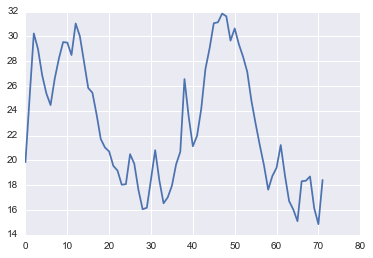

In [1282]:
plt.plot(mean_tc[:,22])

In [1283]:
mean_tc[:,22]

array([ 19.86,  25.12,  30.24,  28.98,  26.86,  25.4 ,  24.46,  26.6 ,
        28.22,  29.54,  29.5 ,  28.5 ,  31.04,  30.02,  27.94,  25.84,
        25.46,  23.7 ,  21.72,  21.04,  20.72,  19.56,  19.18,  18.04,
        18.08,  20.5 ,  19.74,  17.62,  16.06,  16.18,  18.48,  20.82,
        18.38,  16.54,  17.02,  17.96,  19.68,  20.7 ,  26.56,  23.54,
        21.14,  21.98,  24.14,  27.36,  29.04,  31.06,  31.14,  31.84,
        31.62,  29.66,  30.64,  29.36,  28.36,  27.14,  24.8 ,  22.96,
        21.22,  19.6 ,  17.64,  18.74,  19.4 ,  21.24,  18.8 ,  16.72,
        16.04,  15.1 ,  18.32,  18.36,  18.7 ,  16.14,  14.86,  18.42])

In [1326]:
mu1

<tf.Tensor 'Cast_380:0' shape=(113,) dtype=float64>

In [ ]:
k1, mu1, k2, mu2, weight = params
#x = tf.cast(tf.constant((np.arange(-36,36) / 72.0) * 2.0 * np.pi), tf.float64)
#return (tf.exp(k1 * tf.cos(x - mu1))) / (2.0 * np.pi) * i0(k1)

first_term = weight * (tf.exp(k1 * tf.cos(x - mu1)) / (2.0 * np.pi) * i0(k1))

second_term = (1.0 - weight) * (tf.exp(k2 * tf.cos(x - mu2)) / (2.0 * np.pi) * i0(k2))
return first_term + second_term

In [ ]:
s[]

In [1347]:
_i0_1(s[(s <= 8)])

TypeError: unsupported operand type(s) for +: 'Tensor' and 'int'

In [1345]:
_i0_1(20.0).eval()

-5.2796105e+16

In [1350]:
s<=8

<tf.Tensor 'LessEqual_114:0' shape=(2,) dtype=bool>

In [1349]:
tf.where(s<=8).eval()

array([[0]])

In [1351]:
tf.cond((s <= 8), lambda: _i0_1(x), lambda: _i0_2(x))

ValueError: Shape must be rank 0 but is rank 1 for 'cond_95/Switch' (op: 'Switch') with input shapes: [2], [2].

In [1371]:
# MODEL
C = 72 # num orientations
#N = mean_tc.shape[1] # num neurons
N = 2
# mixture of von mises params
k1 = tf.cast(tf.nn.softplus(tf.Variable(tf.random_normal([N]))), tf.float64)
k2 = tf.cast(tf.nn.softplus(tf.Variable(tf.random_normal([N]))), tf.float64)
weight = tf.cast(tf.nn.softplus(tf.Variable(tf.random_normal([N]))), tf.float64)
mu1 = tf.cast(tf.Variable(tf.random_normal([N])), tf.float64)
mu2 = tf.cast(tf.Variable(tf.random_normal([N])), tf.float64)

rates = []
for i in range(N):
    params = [k1[i], mu1[i], k2[i], mu2[i], weight[i]]
    rate = mixture_von_mises(params)
    rates.append(rate)
rate_param = tf.transpose(tf.stack(rates))
y = Poisson(rate = rate_param)

qy = PointMass(params = tf.Variable(tf.zeros([C, N], dtype=tf.float64)))
#inference = ed.MAP({y: qy}, data={y: mean_tc[:,:N]})
#inference.run()
#print(metrics.r2_score(mean_tc[:,, y.mean().eval())) # true vs pred

In [1380]:
mean_tc[:,0:2].shape

(72, 2)

In [1382]:
inference = ed.MAP({y: qy}, data={y: tf.convert_to_tensor(mean_tc[:,0:2])})

In [1383]:
inference.run()

ValueError: Operation 'init_83' has been marked as not fetchable.

In [1322]:
y.mean()

<tf.Tensor 'Poisson_149/mean/Identity:0' shape=(72, 113) dtype=float64>

In [1320]:
y.mean().eval()

array([[ 2.43846052,  2.43846052,  2.43846052, ...,  2.43846052,
         2.43846052,  2.43846052],
       [ 3.15613724,  3.15613724,  3.15613724, ...,  3.15613724,
         3.15613724,  3.15613724],
       [ 4.1016348 ,  4.1016348 ,  4.1016348 , ...,  4.1016348 ,
         4.1016348 ,  4.1016348 ],
       ..., 
       [ 1.37271754,  1.37271754,  1.37271754, ...,  1.37271754,
         1.37271754,  1.37271754],
       [ 1.57052093,  1.57052093,  1.57052093, ...,  1.57052093,
         1.57052093,  1.57052093],
       [ 1.91885846,  1.91885846,  1.91885846, ...,  1.91885846,
         1.91885846,  1.91885846]])

In [1323]:
metrics.r2_score(mean_tc, y.mean().eval())

/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:471: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value, it will be changed to 'uniform_average' in 0.18.
  DeprecationWarning)


-3.3221583496732667

In [1308]:
stacks = []
for i in range(mean_tc.shape[1]):
    stacks.append(rate)

In [1309]:
tf.transpose(tf.stack(stacks))

<tf.Tensor 'transpose_1:0' shape=(72, 113) dtype=float64>

In [1310]:
mean_tc.shape

(72, 113)

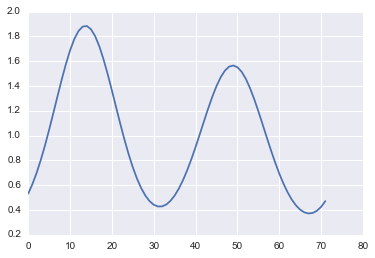

In [1293]:
plt.plot(y.mean().eval())

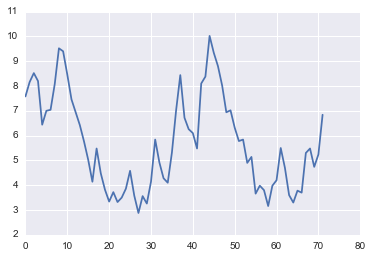

In [1294]:
plt.plot(mean_tc[:,42])

In [1274]:
mean_tc[:,0]

array([  8.5 ,  19.98,  21.44,  18.42,  12.14,   8.06,   7.86,   8.7 ,
         9.94,  11.8 ,  10.06,   8.02,   6.08,   4.6 ,   3.94,   2.8 ,
         2.7 ,   2.54,   1.8 ,   1.62,   1.16,   1.6 ,   1.72,   1.68,
         2.96,   3.94,   2.  ,   1.82,   1.36,   1.8 ,   3.92,   6.62,
         3.3 ,   2.88,   5.04,   7.06,  14.72,  22.2 ,  22.7 ,  20.22,
        16.42,  11.32,  10.18,  11.72,  13.22,  14.44,  11.36,   8.54,
         6.4 ,   4.92,   2.58,   2.3 ,   2.7 ,   1.92,   2.12,   2.28,
         1.78,   1.44,   1.84,   2.06,   3.42,   3.2 ,   1.68,   1.52,
         1.72,   1.96,   3.52,   6.4 ,   4.68,   2.94,   3.98,   5.  ])

In [1240]:
k1.eval(), mu1.eval(), k2.eval(), mu2.eval(), weight.eval()

(7.6489768028259277,
 0.32976529002189636,
 2.4321417808532715,
 -2.8040146827697754,
 0.00011157367407577112)

In [1269]:
rate.eval() == y.mean().eval()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

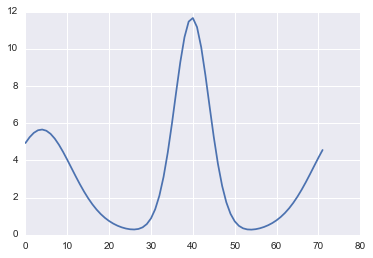

In [1259]:
plt.plot(y.mean().eval())

In [ ]:
plt.plot(y.eval(

In [1262]:
ymean = y.mean().eval()

In [1266]:
metrics.r2_score(mean_tc[:,1], ymean, mean_tc[:,1])

ValueError: setting an array element with a sequence.

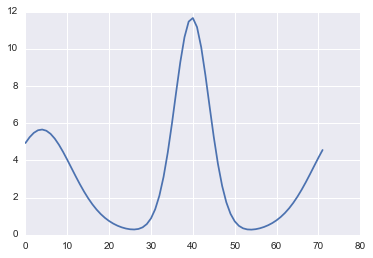

In [1244]:
plt.plot(rate.eval())

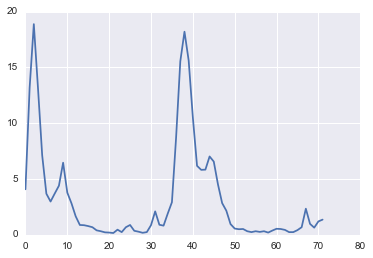

In [1205]:
plt.plot(mean_tc[:,1])

In [ ]:

cov = tf.cast(tf.matrix_inverse(precision)[:-1,:-1], tf.float32)

neuron_cov = tf.nn.softplus(tf.Variable(tf.random_normal([D,D])))

kron_prod = kronecker(cov, neuron_cov) + .1 * np.identity(D*(C-1))

########## MODEL ##########
X = tf.placeholder(tf.float32, [N, D])

vec_w = MultivariateNormalFullCovariance(loc = tf.zeros([D*(C-1)]), covariance_matrix = kron_prod)

b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))
logits = tf.matmul(X, tf.reshape(vec_w, (D, C-1))) + b

In [426]:
k1 = tf.nn.softplus(tf.Variable(tf.random_normal([]))) # k1 > 0
k2 = tf.nn.softplus(tf.Variable(tf.random_normal([]))) # k2 > 0
mu1 = tf.cast(tf.Variable(tf.random_normal([])), tf.float32)
mu2 = tf.Variable(tf.random_normal([]))
weight = tf.nn.softplus(tf.Variable(tf.random_normal([]))) # constrained to be 0 < w < 1
x = tf.cast(tf.reshape(tf.convert_to_tensor((np.arange(-36,36) / 72.0) * 2.0 * np.pi), (-1,1)), tf.float32)
f = mixture_von_mises(x, k1, k2, mu1, mu2, weight)

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

In [420]:
np.i0(10.0),i0(10.0), np.random.vonmises(0, 10.0)

(array(2815.716628466254), 2815.716628466254, -0.13090394980182207)

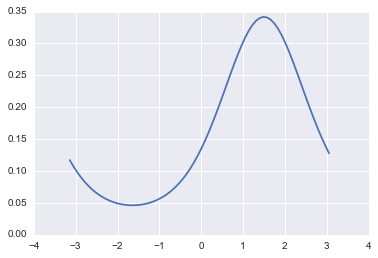

In [352]:
x = (np.arange(-36,36) / 72) * 2 * np.pi
k1 = 1
k2 = 10
mu1 = 1.5
mu2 = 10
weight = .3
plt.plot(x, mixture_von_mises(x, k1, k2, mu1, mu2, weight))

In [333]:
from scipy.stats import vonmises

In [322]:
from scipy.special import j0
j0(.3)

0.97762624653829611

In [319]:
from scipy import special
special.i0(.3)

1.0226268793515974

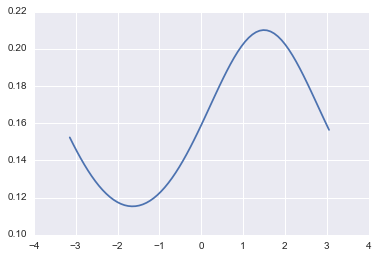

In [330]:
plt.plot(x, vonmises.pdf(x, kappa=.3, loc=1.5))

In [13]:
# path to mat file from Graf 2011
file_path = '../../data/graf_V1data/array_3.mat'

# read and process data
spike_times, orientation_per_trial, num_neurons, orientations, trial_length,\
    num_repeats, num_trials, num_orientations = read_data(file_path)

# compute spike counts
spike_counts = compute_spike_counts(spike_times, num_neurons, num_trials)

# compute tuning curves
mean_tc = compute_mean_tc(spike_counts)
var_tc = compute_var_tc(spike_counts)
cov_tc = compute_cov_tc(spike_counts)

# identify indices for well-tuned neurons
ind_well_tuned = filter_to_well_tuned_neurons(mean_tc, 10)

# normalize spike counts
spike_counts_norm = normalize_spike_counts(spike_counts, num_orientations, num_neurons, num_repeats)

# compute normalized tuning curves
mean_tc_norm = compute_mean_tc(spike_counts_norm)
var_tc_norm = compute_var_tc(spike_counts_norm)
cov_tc_norm = compute_cov_tc(spike_counts_norm)

In [ ]:
spike_counts.shape

In [ ]:
mean_tc[:,0].shape

In [ ]:
from scipy.stats import vonmises
kappa = 3.99
x = np.linspace(vonmises.ppf(0.01, kappa), vonmises.ppf(0.99, kappa), 100)

In [ ]:
plt.plot(x)

In [ ]:
from scipy.special import j0
# besel function of the 0th order
j0(5)

In [355]:
def von_mises(k1, k2, mu1, mu2, x):
    first_term = tf.exp(k1 * tf.cos(x-mu1)) / (2 * np.pi * j0(k1))
    second_term = tf.exp(k2 * tf.cos(x-mu2)) / (2 * np.pi * j0(k2))
    

In [ ]:
k1 = tf.Variable(tf.random_)

In [ ]:
plt.plot(mean_tc[:,0])

In [ ]:
plt.plot(mean_tc[:,1])

In [ ]:
# plot mean tuning curve for 10 well tuned neurons
%matplotlib inline
sns.set_style("darkgrid")
plt.plot(orientations, mean_tc[:, ind_well_tuned[0:10]]);

In [ ]:
# plot variance tuning curve for 10 well tuned neurons
plt.plot(orientations, var_tc[:, ind_well_tuned[0:10]]);

## EVALUATION METRICS
1) Figure 4 from Graf '11 measuring orientation discrimination accuracy.
Compute likelihood ratio tests between $\theta$ and $\theta + \delta \theta$ where $\delta = \in \{5, 10, 15, 20, 25, 30\}$ across all 72 values of $\theta$. So train each model on 35 samples and test on 15 for each class.

In [14]:
def likelihood_ratio_test(likelihood_one, likelihood_two):
    diff = likelihood_one - likelihood_two
    diff[diff > 0] = 1
    diff[diff < 0] = 2
    return diff

def likelihood(w_i, r_i, b_i):
    '''Compute data likelihood given w, r, b for stimulus i'''
    #return np.log(np.sum(np.dot(w_i, r_i.T)) + b_i)
    return np.log(np.dot(w_i, r_i.T) + b_i)
    

def evaluate_model(x_test, w, b):    
    probabilities = np.zeros((72, 6)) # orientations x deltas
    deltas = [1, 2, 3, 4, 5, 6]
    # for each ori
    for i in range(72):
        # for each delta
        for delta in deltas:
            test_data = (np.concatenate((x_test[i], x_test[(i+delta) % 72])))
            test_labels = np.repeat(np.arange(1,3), 15)
            likelihoods_one = likelihood(w[i], test_data, b[i])
            likelihoods_two = likelihood(w[(i+delta) % 72], test_data, b[(i+delta) % 72])
            pred_labels = likelihood_ratio_test(likelihoods_one, likelihoods_two)
            probabilities[i][delta-1] = sklearn.metrics.accuracy_score(pred_labels, test_labels)
    return np.mean(probabilities, axis=0)

In [15]:
def multiclass_log_likelihood(c, w, x, b):
    logit = np.dot(w[c], x.T) + b[c]
    numerator = np.exp(logit)
    denominator = 0
    C = 36
    for i in range(C):
        denominator = denominator + np.exp(np.dot(w[i], x.T) + b[i])
    return np.log(numerator / denominator)

def evaluate_multiclass_model(x, w, b):    
    deltas = [1, 2, 3, 4, 5, 6]
    C = 36
    probabilities = np.zeros((C, len(deltas))) # orientations x deltas

    # for each ori
    for i in range(C):
        # for each delta
        for delta in deltas:
            test_data = (np.concatenate((x[i], x[(i+delta) % C])))
            test_labels = np.repeat(np.arange(1,3), 15)
            likelihoods_one = multiclass_log_likelihood(i, w, test_data, b)
            likelihoods_two = multiclass_log_likelihood((i+delta)%C, w, test_data, b)
            pred_labels = likelihood_ratio_test(likelihoods_one, likelihoods_two)
            
            probabilities[i][delta-1] = sklearn.metrics.accuracy_score(pred_labels.astype(int), test_labels)
    return np.mean(probabilities, axis=0)

In [ ]:
evaluate_model(x_test, w, b)

In [16]:
# green is sklearn l1
# blue is with Stan normal(0,1) prior
# yellow is VI with sample covariance prior
# brown is edward normal(0, .1) prior
# red is PID

xticks = [5, 10, 15, 20, 25, 30]
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, w_model.T, b_model))
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, beta, intercept))
#plt.plot(xticks,evaluate_multiclass_model(x_test_scaled, lr.coef_, lr.intercept_))
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, beta_ori, intercept_ori))
#plt.plevaluate_multiclass_model(x_test_scaled, qw_mod.eval().T, qb_mod.eval())

plt.plot(xticks, evaluate_model(x_test_scaled, w, b))
#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, w_vi.T, b_vi))

#plt.plot(xticks,evaluate_multiclass_model(x_test_scaled, qw_mod.eval().T, qb_mod.eval()))
plt.plot(xticks,([ 0.91157407,  0.94722222,  0.97685185,  0.98842593,  0.99583333,
        0.99768519]))
plt.plot(xticks,([ 0.92037037,  0.96435185,  0.98148148,  0.9912037 ,  0.99768519,
        0.99722222]))

#plt.plot(xticks, evaluate_multiclass_model(x_test_scaled, qw_mod.eval().T, qb_mod.eval()))

plt.ylabel("probability correct")
plt.xlabel("orientation difference (degrees)")

NameError: name 'x_test_scaled' is not defined

### Lets build a Poisson Independent Decoder (PID). We assume each neuron's stimulus-specific spike counts is Poisson distributed and statistically independent across neurons. The rate parameter $w_i(\theta)$ is the logarithm of the mean neuronal tuning function for neuron i across trials for stimulus $\theta$.

### The likelihood function is $\log L(\theta) = \sum_{i=1}^N w_i(\theta)r_i + b(\theta)$. The offset b incorporates overall bias in coverage of orientations and is the sum of the mean tuning curve across neurons for stimulus $\theta$.

In [16]:
def compute_mean_tc_training(x):
    '''compute mean tuning curve (mean of samples for a given orientation,neuron) given training data (orientation,samples) x neurons'''
    mean_tc = np.zeros((x.shape[0], x.shape[2]))
    for i in range(72):
        mean_tc[i] = np.mean(x[i], axis = 0)
    return mean_tc

In [17]:
# filter to well-tuned neurons then rotate axes so we have ori x samples x neurons
spike_counts_filt = np.rollaxis(np.rollaxis(spike_counts[:, ind_well_tuned, :], 2), 1)
#spike_counts_filt = np.rollaxis(np.rollaxis(spike_counts, 2), 1)
# train/test split
inds = np.arange(50)
train_ind = np.random.choice(inds, size = 35, replace = False)
test_ind =  np.array([x for x in inds if x not in train_ind])
x_train, x_test = spike_counts_filt[:, train_ind, :], spike_counts_filt[:, test_ind, :]
# compute mean training curve on training data
mean_tc_train = compute_mean_tc_training(x_train)
# weights are log of mean tuning curve
w = np.log(mean_tc_train)
b = np.sum(w, axis=1)

In [20]:
x_train.shape, x_test.shape

((72, 35, 66), (72, 15, 66))

In [21]:
##### 0-180 degrees only
x_train_half = x_train[0:36]
x_test_half = x_test[0:36]

In [22]:
x_train_half.shape

(36, 35, 66)

In [18]:
def likelihood_(w_i, r_i, b_i):
    '''Compute data likelihood given w, r, b for stimulus i'''
    return np.log(np.sum(np.dot(w_i, r_i.T)) + b_i)

In [19]:
def plot_likelihood(w, x_train, b, stimulus_choice):
    '''plot likelihood of stimulus-specific spike train as a function of model choice'''
    sx = []
    for i in range(72):
        sx.append(likelihood(w[i], x_train[stimulus_choice], b[i]))
    fig = plt.plot(sx)

In [20]:
def likelihood_ratio_test_(w, x_train, b, ori1, ori2):
    '''given a population response, compute likelihood ratio test comparing two orientation models'''
    val = likelihood(w[ori1], x_train, b[ori1]) - likelihood(w[ori2], x_train, b[ori2])
    if val > 0:
        return ori1
    else:
        return ori2

In [ ]:
# likelihood comparison -- which model provides best explanation of the data?,
plot_likelihood(w, x_train, b, 1) # for example, we fit spike trains from ori 1 against all possible models
plot_likelihood(w, x_test, b, 1)

In [25]:
Xtrain.shape

(1260, 66)

## DATA Processing 

In [21]:
### DATA PROCESSING

num_classes = 72
C = 72


Xtrain = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])
Xtest = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])
Ytrain = np.repeat(np.arange(C), x_train.shape[1])
Ytest = np.repeat(np.arange(C), x_test.shape[1])


#Xtrain = x_train.reshape(x_train.shape[0] * x_train.shape[1], x_train.shape[2])
#Xtest = x_test.reshape(x_test.shape[0] * x_test.shape[1], x_test.shape[2])

#Ytrain = np.repeat(np.arange(72), x_train.shape[1])
#Ytest = np.repeat(np.arange(72), x_test.shape[1])

N,D = Xtrain.shape[0], Xtrain.shape[1]

Xtrain_scaled = sklearn.preprocessing.scale(Xtrain)
Xtest_scaled = sklearn.preprocessing.scale(Xtest)
Ytrain_hot = tf.one_hot(Ytrain, depth=C).eval()
Ytest_hot = tf.one_hot(Ytest, depth=C).eval()

x_train_scaled_3d = np.zeros((num_classes,35,D))
x_test_scaled_3d = np.zeros((num_classes,15,D))
for i in range(num_classes):
    x_test_scaled_3d[i] = Xtest_scaled[i*15:i*15+15]
    x_train_scaled_3d[i] = Xtrain_scaled[i*35:i*35+35]


### Lets build a L1 regularized multinomial multi-class logistic regression model

In [22]:
# specify model
lr = sklearn.linear_model.LogisticRegression(penalty='l1', fit_intercept=True)

# fit the model
lr.fit(Xtrain_scaled, np.repeat(np.arange(C),35))

## predict labels and probability distributions on test data
#labels_test = lr.predict(sklearn.preprocessing.scale(Xtest_scaled))
#scores_test = lr.predict_proba(sklearn.preprocessing.scale(Xtest_scaled))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [235]:
x_test_scaled_3d.shape

(72, 15, 66)

In [23]:
evaluate_multiclass_model(x_test_scaled_3d, lr.coef_, lr.intercept_)

array([ 0.81944444,  0.95648148,  0.98611111,  0.99351852,  0.99722222,
        0.99722222])

In [24]:
def evaluate_one_versus_all(y_test, scores):
    '''AUC scores for one versus all classification on test data across all classes'''
    aucs = []
    for j in range(72):
        sx = []
        for i in range(len(y_test)):
            if y_test[i] == (j+1):
                sx.append(int(1))
            else:
                sx.append(int(0))
        aucs.append(sklearn.metrics.roc_auc_score(np.array(sx),scores[:,j]))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

In [25]:
def evaluate_one_versus_one(y_test, scores, delta):
    '''AUC scores for one class versus one class on test data across all classes
        delta, int : discriminate between class and class + delta    
    '''
    aucs = []
    for j in range(1,73):
        inds = np.concatenate((np.where(y_test == (j))[0], np.where(y_test == (((j-1)+delta) % 72) + 1)[0]))
        #print(y_test[inds])
        #print(scores[inds,j-1])
        y = (y_test[inds] == j).astype(int)
        aucs.append((sklearn.metrics.roc_auc_score(y, scores[inds,j-1])))
    plt.figure(figsize=(10,5))
    plt.scatter(np.arange(72),aucs)
    plt.xlabel('class')
    plt.ylabel('auc')

In [ ]:
evaluate_one_versus_one(y_test, scores_test, 1)
evaluate_one_versus_one(y_test, scores_test, 2)
evaluate_one_versus_one(y_test, scores_test, 5)
evaluate_one_versus_one(y_test, scores_test, 10)
evaluate_one_versus_one(y_test, scores_test, 20)

## SVM model from Graf 11

In [26]:
from sklearn import svm

In [183]:
aucs_svm = []
w_hat_svm = []
b_hat_svm = []
C = 72

aucs_svm_local = []
for i in range(0,C):
    clf = svm.SVC(kernel='linear')
    #train_data = np.concatenate([x_train[(i+d)%72], x_train[i]])
    #test_data = np.concatenate([x_test[(i+d)%72], x_test[i]])

    train_data = np.concatenate([x_train[(i+1)%C], x_train[i]])
    test_data = np.concatenate([x_test[(i+1)%C], x_test[i]])
    clf.fit(train_data, np.repeat(np.arange(-1,2, step=2), 35))
    w_hat_svm.append(clf.coef_[0])
    b_hat_svm.append(clf.intercept_[0])

    aucs_svm_local.append(sklearn.metrics.accuracy_score(clf.predict(test_data), np.repeat([-1,1],15)))
    aucs_svm.append(np.mean(aucs_svm_local))
w_hat_svm = np.array(w_hat_svm)
b_hat_svm = np.array(b_hat_svm)

In [248]:
def compute_ll(stimulus, weights, intercepts, data):
    '''
    log L(\theta_i) = \sum_{k=2}^i log LR(\theta_k, \theta_{k-1})
    
    '''
    log_likelihood = 0
    for i in range(1, stimulus+1):
        log_likelihood = log_likelihood + compute_log_lr(i, weights, intercepts, data)
    return log_likelihood / np.sum(log_likelihood)
def compute_log_lr(stimulus, weights, intercepts, data):
    ll = np.sum(weights[stimulus-1]*data,axis=1) + intercepts[stimulus-1]
    return ll

In [168]:
data = np.concatenate([x_test[(1)%C], x_test[2]])
x = compute_ll(2, w_svm, b_svm, data) - compute_ll(3, w_svm, b_svm, data)
sklearn.metrics.accuracy_score(np.repeat(np.arange(0,2), 15), x > 0)

0.0

In [169]:
w_hat_svm.shape

(72, 66)

In [170]:
b_hat_svm.shape

(72,)

In [180]:
C, N = w_hat_svm.shape[0], w_hat_svm.shape[1]
w_svm = np.zeros((C,N))
b_svm = np.zeros(C)

for i in range(0,C):
    if i == 0: 
        w_svm[i] = np.zeros(N)
        b_svm[i] = 0
        continue
    w_svm[i] = w_svm[i-1] + w_hat_svm[i-1]
    b_svm[i] = b_svm[i-1] + b_hat_svm[i-1]
    

# normalize
w_svm = w_svm / np.reshape(np.sum(w_svm, axis=1), (-1,1))
w_svm[0] = np.zeros(N)

In [181]:
evaluate_multiclass_model(x_test_scaled_3d, w_svm, b_svm)

array([ 0.44814815,  0.43425926,  0.43703704,  0.4462963 ,  0.47407407,
        0.43796296])

In [275]:
acc = []
for i in range(1, C):
    data = np.concatenate([x_test[(i)%C], x_test[((i+10)%C)]])
    log_likelihood_i = compute_ll(i, w_hat_svm, b_hat_svm, data)
    log_likelihood_i_plus_1 = compute_ll((i+10)%C, w_hat_svm, b_hat_svm, data)
    x = log_likelihood_i - log_likelihood_i_plus_1
    acc.append(sklearn.metrics.accuracy_score(np.repeat(np.arange(0,2), 15), x < 0))

In [276]:
np.mean(acc)

0.68122065727699532

In [259]:
compute_ll(C-1, w_hat_svm, b_hat_svm, data)

array([ 0.04358428,  0.04462624,  0.02527282,  0.01699148,  0.00352606,
        0.0138918 ,  0.00766797,  0.01155578,  0.01316951,  0.00548474,
        0.01436658, -0.00153513,  0.01276006,  0.00499265,  0.01292997,
        0.06906121,  0.06034079,  0.06808381,  0.03667716,  0.03961471,
        0.06016069,  0.04457537,  0.03792271,  0.03977237,  0.05373008,
        0.06274275,  0.05046174,  0.0473069 ,  0.04732739,  0.05293749])

In [269]:
data = np.concatenate([x_test[(C-2)%C], x_test[((C-1)%C)]])
x = compute_ll(C-2, w_hat_svm, b_hat_svm, data) - compute_ll(C-1, w_hat_svm, b_hat_svm, data)
sklearn.metrics.accuracy_score(np.repeat(np.arange(0,2), 15), x < 0)

0.066666666666666666

In [267]:
compute_ll(C-2, w_hat_svm, b_hat_svm, data)

array([ 0.07976971,  0.06673839,  0.06896751,  0.04049694,  0.02383212,
        0.02560391,  0.02672641,  0.03333536,  0.03595647, -0.04683261,
       -0.00365892, -0.03983441, -0.0280012 ,  0.04100138, -0.01848441,
        0.13096801,  0.12996302,  0.07169049,  0.05143654,  0.01237513,
        0.04380755,  0.01959891,  0.03304092,  0.03933904,  0.01872356,
        0.04289289,  0.00192537,  0.04039852,  0.01573852,  0.04248492])

In [268]:
compute_ll(C-1, w_hat_svm, b_hat_svm, data)

array([ 0.08540468,  0.06725487,  0.07189402,  0.04044976,  0.02845863,
        0.02836341,  0.03000028,  0.03867379,  0.04197931, -0.04422898,
        0.00129172, -0.03952105, -0.02635223,  0.04448214, -0.01539986,
        0.12303433,  0.1259757 ,  0.0713428 ,  0.04796536,  0.00995375,
        0.03921526,  0.02164595,  0.03262088,  0.03717628,  0.01548291,
        0.0405555 , -0.00433352,  0.03602044,  0.01409378,  0.03650008])

In [270]:
compute_ll(C-2, w_hat_svm, b_hat_svm, data) - compute_ll(C-1, w_hat_svm, b_hat_svm, data)

array([ -5.63496728e-03,  -5.16485609e-04,  -2.92651549e-03,
         4.71783403e-05,  -4.62651562e-03,  -2.75950160e-03,
        -3.27387680e-03,  -5.33842777e-03,  -6.02284043e-03,
        -2.60362601e-03,  -4.95064071e-03,  -3.13364682e-04,
        -1.64896994e-03,  -3.48076349e-03,  -3.08454626e-03,
         7.93367609e-03,   3.98732199e-03,   3.47686430e-04,
         3.47117106e-03,   2.42137916e-03,   4.59229039e-03,
        -2.04704956e-03,   4.20039107e-04,   2.16275604e-03,
         3.24064780e-03,   2.33739115e-03,   6.25888916e-03,
         4.37807962e-03,   1.64474647e-03,   5.98483846e-03])

In [385]:
# write a function that computes log L(data; stimulus) -> so we specify the data and what stimulus we want and then we get log likelihood values

In [347]:
log_ll_svm = np.zeros((72,70))
for i in range(C):
    if i == 0:
        log_ll_svm[i] = 0
        continue
    r = np.concatenate([x_train[(i-1)%C], x_train[i]])
    llr = np.sum(w_svm[i]*r, axis=1) + b_svm[i]
    llr = llr / np.sum(llr) # scale llrs
    log_ll_svm[i] = log_ll_svm[i-1] + llr

In [356]:
log_ll_svm = np.zeros((72,70))
w_d = np.zeros((72,66))
w_svm[0] = 0
for i in range(C):
    w_d[i] = w_svm[(i+1)%C] - w_svm[i]

In [357]:
w_d

array([[-0.00780162, -0.02538135, -0.01285947, ...,  0.01064625,
         0.00416119, -0.00745489],
       [ 0.01016356,  0.02862334,  0.0015774 , ..., -0.00854087,
         0.01254639,  0.00528252],
       [ 0.01562254,  0.04733449, -0.02445935, ...,  0.00323274,
         0.0027448 , -0.00191086],
       ..., 
       [ 0.05488365,  0.01229697,  0.00454152, ..., -0.0244175 ,
        -0.00343365,  0.02993379],
       [-0.00735064, -0.00951106, -0.00539935, ..., -0.01061533,
         0.01910915, -0.01344544],
       [-0.00025439,  0.00695712, -0.00223221, ...,  0.02283983,
        -0.00261978, -0.01291241]])

In [344]:
np.sum(w_svm[0]*r, axis=1) + b_svm[0]

array([ 3.61330046,  2.56464045,  2.03756082,  2.44418738,  2.74065742,
        1.85330084,  3.81862399,  2.52582376,  3.85899648,  2.65572377,
        2.94858623,  3.98599346,  3.45944799,  2.94943077,  2.61505058,
        2.94798479,  2.08504589,  3.08739288,  2.92888464,  2.30167625,
        2.80233979,  2.21478283,  3.25631735,  3.13889484,  2.68246207,
        2.55969725,  2.30358881,  2.90440798,  2.71754126,  1.80195695,
        1.32249996,  3.15898258,  2.38556443,  1.81585779,  3.07148664,
        2.88500923,  2.22155426,  2.01579145,  3.76670941,  1.79281343,
        1.68520942,  3.50151403,  2.84818844,  2.24310858,  2.7596632 ,
        2.35713918,  2.89026073,  2.87976437,  2.49630308,  2.82758617,
        2.17053346,  2.34667721,  1.82665937,  1.59155578,  1.72729581,
        2.09053037,  2.34920065,  3.07437143,  2.87205435,  2.82992113,
        1.78188986,  3.14084388,  2.38658102,  2.6524941 ,  2.29643785,
        1.48922007,  3.38214053,  2.80219672,  2.19008901,  2.84

In [330]:
log_ll_svm

array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   3.10986624,    2.57714643,    3.13005735, ...,    0.99958555,
           0.99966977,    1.31169172],
       [   5.59068993,    5.43461025,    6.5607529 , ...,    2.24206468,
           2.58269256,    3.89885701],
       ..., 
       [ 196.34640817,  222.99713332,  223.61414606, ...,  117.70292896,
          95.4575153 ,  108.18123393],
       [ 198.28610113,  227.3345811 ,  227.52521459, ...,  118.70339009,
          96.45723921,  109.18130487],
       [ 200.62194598,  229.76633405,  229.83500172, ...,  119.70326342,
          97.4567742 ,  110.49577146]])

In [ ]:
# subset of tuned neurons, with single tau
plt.plot([1,2,3,4,5,6], aucs_svm)
plt.plot([1,2,3,4,5,6], evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

In [ ]:
plt.plot([1,2,3,4,5,6], aucs_svm)
plt.plot([1,2,3,4,5,6], evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

In [ ]:
# all neurons, sparsity param for each class 

plt.plot([1,2,3,4,5,6], aucs_svm)
plt.plot([1,2,3,4,5,6], 

In [ ]:
tau.eval()

In [ ]:
qw_mod = tf.concat([qw.mean(), np.zeros((D,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

In [ ]:
qw_mod = tf.concat([qw.mean(), np.zeros((D,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

### Lets build a Bayesian multinomial multi-class logistic regression model
$$p(\theta^{(i)} = c | r^{(i)}, w^{(c)}) = \frac{\exp{(w^{(c)T}r^{(i)})}}{\sum_{j=1}^C(w^{(j)T}r^{(i)})}$$
$$p(w^{(c)}|\Lambda^{(c)}) = \mathcal{N}(0, \Lambda^{(c)}), \Lambda^{(c)} \in \mathcal{R^{\text{NxN}}}$$

In [50]:
def compute_average_auc(predictions, labels):
    classes = labels.shape[1]
    aucs = np.zeros((classes))
    for i in range(classes):
        aucs[i] = sklearn.metrics.roc_auc_score(labels[:,i], predictions[:,i])
    return np.mean(aucs)

In [505]:
(tf.random_normal([D,D]) * np.identity(D)).eval()

array([[ 3.07695556, -0.        , -0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.        ,  0.32832348,  0.        , ..., -0.        ,
         0.        , -0.        ],
       [-0.        , -0.        ,  0.95014298, ..., -0.        ,
        -0.        ,  0.        ],
       ..., 
       [ 0.        , -0.        ,  0.        , ..., -0.46595553,
        -0.        , -0.        ],
       [ 0.        , -0.        , -0.        , ..., -0.        ,
         0.26682189, -0.        ],
       [ 0.        , -0.        , -0.        , ..., -0.        ,
         0.        , -0.00951146]], dtype=float32)

In [508]:
tf.cholesky((tf.random_normal([D,D]) * np.identity(D))).eval()

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: Cholesky_31 = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](mul_1032)]]

Caused by op 'Cholesky_31', defined at:
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2831, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-508-a204de0657eb>", line 1, in <module>
    tf.cholesky((tf.random_normal([D,D]) * np.identity(D))).eval()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 227, in cholesky
    result = _op_def_lib.apply_op("Cholesky", input=input, name=name)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: Cholesky_31 = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](mul_1032)]]


## does modeling neuron x neuron cov help?

In [513]:
# DATA
sess = ed.get_session()
# N is number of samples (ori x trials) and D is number of neurons
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

########## DESIGN COVARIANCE MATRIX ##########

cov = tf.nn.softplus(tf.Variable(tf.random_normal([D,D])))

#cov = tf.nn.softplus(tf.Variable(tf.random_normal([D,D]))) + .1 * np.identity(D)


########## MODEL ##########
X = tf.placeholder(tf.float32, [N, D])

w = MultivariateNormalFullCovariance(loc = tf.zeros([C-1,D]), covariance_matrix = tf.cholesky(cov))
b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))
logits = tf.matmul(X, tf.transpose(w)) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(logits = logits)

########## INFERENCE ##########
qw_loc = tf.Variable(tf.random_normal([C-1, D]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([C-1, D])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 3000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: inference_7067801248/0/Cholesky_32 = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](inference_7067801248/0/Softplus_285)]]

Caused by op 'inference_7067801248/0/Cholesky_32', defined at:
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-513-abed67a02051>", line 33, in <module>
    inference.initialize(n_iter = 3000)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py", line 86, in initialize
    return super(KLqp, self).initialize(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/variational_inference.py", line 75, in initialize
    self.loss, grads_and_vars = self.build_loss_and_gradients(var_list)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py", line 129, in build_loss_and_gradients
    return build_reparam_loss_and_gradients(self, var_list)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py", line 383, in build_reparam_loss_and_gradients
    z_copy = copy(z, dict_swap, scope=scope)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/util/random_variables.py", line 228, in copy
    kwargs[key] = copy_default(value, dict_swap, scope, True, copy_q)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/util/random_variables.py", line 84, in copy_default
    x = copy(x, *args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/util/random_variables.py", line 244, in copy
    new_op = copy(op, dict_swap, scope, True, copy_q)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/util/random_variables.py", line 290, in copy
    op_def)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: inference_7067801248/0/Cholesky_32 = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](inference_7067801248/0/Softplus_285)]]


# tridiagonal prior -> variational EM 

In [ ]:
def design_precision_matrix():
    w_covs = []
    tau = tf.nn.softplus(tf.Variable(tf.random_normal([D])))
    sparsity = tf.nn.softplus(tf.Variable(tf.random_normal([D])))
    # for each neuron
    for d in range(D):
        # Design precision matrix
        A = np.zeros((C-1,C))
        for i in range(C-1):
            A[i,i] = -1
            A[i,i+1] = 1
        precision = A.T.dot(A) #+ .1 * np.identity(C) # precision = A^T.dot(A)
        precision = tau[d] * precision + sparsity[d] * np.identity(C)
        precision = precision + .1 * np.identity(C) # guarantees full rank

        cov = tf.matrix_inverse(precision)[:-1,:-1]
        w_covs.append(cov)
    
    w_cov = tf.stack(w_covs)

        #w_cov = tf.tile(tf.expand_dims(cov, 0), [D, 1, 1])
    return w_cov
    

In [44]:
Xtrain_scaled.shape, Ytrain.shape

((1260, 66), (2520,))

In [ ]:
# for each neuron
for d in range(D):
    # Design precision matrix
    A = np.zeros((C-1,C))
    # for each orientation
    for i in range(C-1):
        A[i,i] = -1
        A[i,i+1] = 1
    precision = A.T.dot(A) #+ .1 * np.identity(C) # precision = A^T.dot(A)
    precision[0,0] = 2.0
    precision[C-1, C-1] = 2.0
    precision[0, C-1] = -1.0
    precision[C-1, 0] = -1.0
    
    precision = precision + sparsity * np.identity(C)
    precision = precision + .1 * np.identity(C) # guarantees full rank

    cov = tf.matrix_inverse(precision)[:-1,:-1]
    w_covs.append(tf.cast(cov, tf.float64))
w_cov = tf.stack(w_covs)

In [ ]:
precision

In [434]:
# Design precision matrix
A = np.zeros((C-1,C))
# for each orientation
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) #+ .1 * np.identity(C) # precision = A^T.dot(A)



In [435]:
precision

array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [438]:
A

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [ ]:
precision[0,0] = 2
precision[C-1, C-1] = 2
precision[0, C-1] = -1
precision[C-1, 0] = -1

In [439]:
# DATA
sess = ed.get_session()
# N is number of samples (ori x trials) and D is number of neurons
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

########## DESIGN COVARIANCE MATRIX ##########
w_covs = []
#tau = tf.nn.softplus(tf.Variable(tf.random_normal([D])))
tau = tf.nn.softplus(tf.Variable(tf.random_normal([D])))

#sparsity = tf.nn.softplus(tf.Variable(tf.random_normal([D])))
sparsity = tf.nn.softplus(tf.Variable(tf.random_normal([])))


# for each neuron
for d in range(D):
    # Design precision matrix
    A = np.zeros((C-1,C))
    # for each orientation
    for i in range(C-1):
        A[i,i] = -1
        A[i,i+1] = 1
    precision = A.T.dot(A) #+ .1 * np.identity(C) # precision = A^T.dot(A)
    precision = tau[d] * precision + sparsity * np.identity(C)
    precision = precision + .1 * np.identity(C) # guarantees full rank

    cov = tf.matrix_inverse(precision)[:-1,:-1]
    w_covs.append(cov)
w_cov = tf.stack(w_covs)

########## MODEL ##########
X = tf.placeholder(tf.float32, [N, D])
w = MultivariateNormalFullCovariance(loc = tf.zeros([D,C-1]), covariance_matrix = tf.cast(w_cov, tf.float32))
b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))
logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(logits = logits)

########## INFERENCE ##########
qw_loc = tf.Variable(tf.random_normal([D, C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 3000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

{'t': 1, 'loss': 76521.016}
{'t': 101, 'loss': 9734.5498}
{'t': 201, 'loss': 7118.5664}
{'t': 301, 'loss': 6898.1997}
{'t': 401, 'loss': 6120.0596}
{'t': 501, 'loss': 6192.7383}
{'t': 601, 'loss': 6096.2578}
{'t': 701, 'loss': 5999.6538}
{'t': 801, 'loss': 5747.8633}
{'t': 901, 'loss': 5227.0811}
{'t': 1001, 'loss': 6023.1987}
{'t': 1101, 'loss': 5398.0654}
{'t': 1201, 'loss': 5188.6304}
{'t': 1301, 'loss': 5179.0459}
{'t': 1401, 'loss': 4920.7388}
{'t': 1501, 'loss': 5314.5898}
{'t': 1601, 'loss': 5199.1455}
{'t': 1701, 'loss': 4849.3906}
{'t': 1801, 'loss': 5242.9043}
{'t': 1901, 'loss': 4936.3003}
{'t': 2001, 'loss': 4767.4097}
{'t': 2101, 'loss': 5226.5532}
{'t': 2201, 'loss': 5237.6997}
{'t': 2301, 'loss': 4867.6362}
{'t': 2401, 'loss': 4701.623}
{'t': 2501, 'loss': 4900.938}
{'t': 2601, 'loss': 4885.106}
{'t': 2701, 'loss': 5189.3833}
{'t': 2801, 'loss': 4792.2871}
{'t': 2901, 'loss': 4619.9199}


In [440]:
########## EVAL ##########
qw_mod = tf.concat([qw.mean(), np.zeros((qw.shape[0],1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

0.99778473309
[ 0.90833333  0.99259259  1.          1.          1.          1.        ]


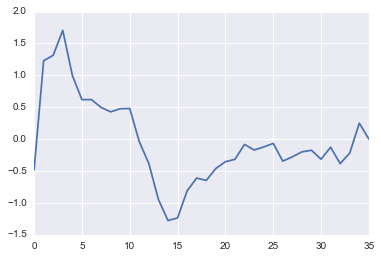

In [106]:
plt.plot(qw_mod.eval()[0])

In [ ]:
tridiag_tau_each_neuron = [0.89212963, 0.98472222, 0.99953704, 0.99953704, 0.99953704, 1.]
tridiag_single_tau = [ 0.88935185  0.99027778  0.99861111  0.99953704  0.99953704  1.        ]
tridiag_single_tau_single_spar = [ 0.90185185  0.98981481  1.          0.99953704  0.99953704  1.        ]

gp = [ 0.90138889  0.99027778  1.          0.99953704  0.99953704  1.        ]

In [ ]:
plt.plot(qw_mod.eval()[3])

In [ ]:
tau.eval()[3]

In [ ]:
########## EVAL ##########
qw_mod = tf.concat([qw.mean(), np.zeros((qw.shape[0],1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(np.arange(len(tau.eval())),tau.eval())
plt.ylabel("tau")
plt.xlabel("neuron")

In [ ]:
plt.scatter(np.arange(113),sparsity.eval())

In [ ]:
plt.figure(figsize=(10,8))
tau_per_neuron_vi = [0.81481481, 0.90185185, 0.96666667, 0.98564815, 0.99444444, 0.99722222]
l2_prior = [0.74027778, 0.81759259, 0.92407407, 0.96342593, 0.98888889, 0.99305556]

xticks = [5, 10, 15, 20, 25, 30]
plt.plot(xticks, l2_prior, label="l2 prior")
plt.plot(xticks, tau_per_neuron_vi, label="new model")
plt.ylabel("probability correct")
plt.xlabel("orientation difference (degrees)")
plt.legend(loc = 'lower right')

In [ ]:
rbf(tf.cast(np.reshape(np.arange((3)), (-1,1)), tf.float32)).eval()

In [ ]:
rbf(tf.cast(np.reshape(np.arange((5)), (-1,1)), tf.float32)).eval()

In [ ]:
x = np.reshape(np.concatenate((np.arange(1,38), np.arange(start=36, stop=1, step=-1))), (-1,1))
rbf(tf.cast(x, dtype=tf.float32))

In [ ]:
np.arange(start=36, stop=1, step=-1)

In [ ]:
len(np.reshape(np.concatenate((np.arange(1,38), np.arange(start=36, stop=2, step=-1))), (-1,1)))

In [ ]:
tf.cholesky(rbf_kernel).eval()

In [60]:
kern = np.reshape(np.arange(0,36), (-1,1))

rbf_kernel = rbf(X = tf.cast(kern, tf.float32))
rbf_kernel = tf.nn.softplus(rbf_kernel + .1 * tf.identity(rbf_kernel))

In [56]:
from edward.util import rbf

In [62]:
rbf_kernel

<tf.Tensor 'Softplus_13:0' shape=(36, 36) dtype=float32>

In [223]:
def rbf_cos_kernel(theta):
    '''
        RBF kernel applied to distances on a circle using radians
    '''
    variance = 1.0
    lengthscale = 1.0
    kernel = np.zeros((len(theta), len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            radians = ((theta[j] - theta[i]) / len(theta)) * 2 * np.pi
            kernel[i,j] = variance * (np.cos(radians) / lengthscale) ** 2
    return kernel

In [224]:
theta = np.reshape(np.arange(0,5), (-1,1))

rbf_cos_kernel(theta)

array([[ 1.       ,  0.0954915,  0.6545085,  0.6545085,  0.0954915],
       [ 0.0954915,  1.       ,  0.0954915,  0.6545085,  0.6545085],
       [ 0.6545085,  0.0954915,  1.       ,  0.0954915,  0.6545085],
       [ 0.6545085,  0.6545085,  0.0954915,  1.       ,  0.0954915],
       [ 0.0954915,  0.6545085,  0.6545085,  0.0954915,  1.       ]])

In [137]:
((theta[2] - theta[1]) / 72) * 2 * np.pi

array([ 0.08726646])

In [ ]:
vec_w = MultivariateNormalFullCovariance(loc = tf.zeros([D,C-1]), covariance_matrix = 

In [445]:
import tensorflow as tf

def kronecker(a, b):
    # cite : https://stackoverflow.com/questions/44309333/what-is-the-most-efficient-way-to-compute-a-kronecker-product-in-tensorflow
    
    i, k, s = len(a), len(b), len(b)
    o = s * (i - 1) + k

    a_tf  = tf.reshape(tf.constant(a, dtype=tf.float32), [1, i, i, 1])
    b_tf = tf.reshape(tf.constant(b, dtype=tf.float32), [k, k, 1, 1])

    res = tf.squeeze(tf.nn.conv2d_transpose(a_tf, b_tf, (1, o, o, 1), [1, s, s, 1], "VALID"))
    return res

In [447]:
a = [[1, 2, 3], [3, 4, 7], [8, 9, 4]]
b = [[0, 5], [6, 7]]
kronecker(a,b).eval()


array([[  0.,   5.,   0.,  10.,   0.,  15.],
       [  6.,   7.,  12.,  14.,  18.,  21.],
       [  0.,  15.,   0.,  20.,   0.,  35.],
       [ 18.,  21.,  24.,  28.,  42.,  49.],
       [  0.,  40.,   0.,  45.,   0.,  20.],
       [ 48.,  56.,  54.,  63.,  24.,  28.]], dtype=float32)

## Matrix normal prior, specifying cov matrix for neuron x neurion and ori x ori

In [468]:
def kronecker(a, b):
    # cite : https://stackoverflow.com/questions/44309333/what-is-the-most-efficient-way-to-compute-a-kronecker-product-in-tensorflow
    
    i, k, s = int(a.shape[0]), int(b.shape[0]), int(b.shape[0])
    
    o = s * (i - 1) + k

    a_tf  = tf.reshape(a, [1, i, i, 1])
    b_tf = tf.reshape(b, [k, k, 1, 1])

    res = tf.squeeze(tf.nn.conv2d_transpose(a_tf, b_tf, (1, o, o, 1), [1, s, s, 1], "VALID"))
    return res

71

In [479]:
# design stimulus x stimulus matrix
w_covs = []
tau = tf.nn.softplus(tf.Variable(tf.random_normal([])))
sparsity = tf.nn.softplus(tf.Variable(tf.random_normal([])))
# for each neuron
# Design precision matrix
A = np.zeros((C-1,C))
# for each orientation
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) #+ .1 * np.identity(C) # precision = A^T.dot(A)
precision = tau * precision + sparsity * np.identity(C)
precision = precision + .1 * np.identity(C) # guarantees full rank

cov = tf.cast(tf.matrix_inverse(precision)[:-1,:-1], tf.float32)

neuron_cov = tf.nn.softplus(tf.Variable(tf.random_normal([D,D])))

kron_prod = kronecker(cov, neuron_cov) + .1 * np.identity(kron_prod.shape[0])

########## MODEL ##########
X = tf.placeholder(tf.float32, [N, D])

vec_w = MultivariateNormalFullCovariance(loc = tf.zeros([D*(C-1)]), covariance_matrix = kron_prod)

In [480]:
tf.cholesky(kron_prod).eval()

FailedPreconditionError: Attempting to use uninitialized value Variable_269
	 [[Node: Variable_269/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_269"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_269)]]

Caused by op 'Variable_269/read', defined at:
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-479-ee18c7100835>", line 18, in <module>
    neuron_cov = tf.nn.softplus(tf.Variable(tf.random_normal([D,D])))
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_269
	 [[Node: Variable_269/read = Identity[T=DT_FLOAT, _class=["loc:@Variable_269"], _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_269)]]


In [490]:
D, C-1, D*(C-1)

(66, 71, 4686)

In [491]:
.1 * np.identity(D*(C-1))

array([[ 0.1,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0.1,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.1, ...,  0. ,  0. ,  0. ],
       ..., 
       [ 0. ,  0. ,  0. , ...,  0.1,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0.1,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0.1]])

In [492]:
# DATA
sess = ed.get_session()
# N is number of samples (ori x trials) and D is number of neurons
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

########## DESIGN COVARIANCE MATRICES ##########

# design stimulus x stimulus matrix
w_covs = []
tau = tf.nn.softplus(tf.Variable(tf.random_normal([])))
sparsity = tf.nn.softplus(tf.Variable(tf.random_normal([])))
# for each neuron
# Design precision matrix
A = np.zeros((C-1,C))
# for each orientation
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) #+ .1 * np.identity(C) # precision = A^T.dot(A)
precision = tau * precision + sparsity * np.identity(C)
precision = precision + .1 * np.identity(C) # guarantees full rank

cov = tf.cast(tf.matrix_inverse(precision)[:-1,:-1], tf.float32)

neuron_cov = tf.nn.softplus(tf.Variable(tf.random_normal([D,D])))

kron_prod = kronecker(cov, neuron_cov) + .1 * np.identity(D*(C-1))

########## MODEL ##########
X = tf.placeholder(tf.float32, [N, D])

vec_w = MultivariateNormalFullCovariance(loc = tf.zeros([D*(C-1)]), covariance_matrix = kron_prod)

b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))
logits = tf.matmul(X, tf.reshape(vec_w, (D, C-1))) + b

logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(logits = logits)

########## INFERENCE ##########
qw_loc = tf.Variable(tf.random_normal([D * (C-1)]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D * (C-1)])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({vec_w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 3000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: inference_6737233344/0/MultivariateNormalTriL/init/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](inference_6737233344/0/add_1044)]]

Caused by op 'inference_6737233344/0/MultivariateNormalTriL/init/Cholesky', defined at:
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-492-f7d278befebe>", line 51, in <module>
    inference.initialize(n_iter = 3000)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py", line 86, in initialize
    return super(KLqp, self).initialize(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/variational_inference.py", line 75, in initialize
    self.loss, grads_and_vars = self.build_loss_and_gradients(var_list)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py", line 129, in build_loss_and_gradients
    return build_reparam_loss_and_gradients(self, var_list)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/inferences/klqp.py", line 383, in build_reparam_loss_and_gradients
    z_copy = copy(z, dict_swap, scope=scope)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/util/random_variables.py", line 232, in copy
    new_rv = type(rv)(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/edward/models/random_variable.py", line 103, in __init__
    super(RandomVariable, self).__init__(*args, **kwargs)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/distributions/python/ops/mvn_full_covariance.py", line 181, in __init__
    scale_tril = linalg_ops.cholesky(covariance_matrix)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 227, in cholesky
    result = _op_def_lib.apply_op("Cholesky", input=input, name=name)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/farhan.damani/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Cholesky decomposition was not successful. The input might not be valid.
	 [[Node: inference_6737233344/0/MultivariateNormalTriL/init/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](inference_6737233344/0/add_1044)]]


In [454]:
########## EVAL ##########
qw_mod = tf.concat([qw.mean(), np.zeros((qw.shape[0],1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

0.997811684924
[ 0.91111111  0.98981481  1.          1.          1.          1.        ]


In [522]:
X = np.array([1, 2, 3, 4, 5, 6])

In [520]:
K(X)

TypeError: slice() missing 1 required positional argument: 'X2'

In [551]:
def periodic_kern(x, p, lengthscale, variance):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = variance * tf.exp(-(2 * np.sin(np.pi * np.abs(x[i] - x[j])/p)**2) / lengthscale**2)
    return k

In [552]:
p = X.shape[0]# C-1 # period
lengthscale = tf.nn.softplus(tf.Variable(tf.random_normal([])))
variance = tf.nn.softplus(tf.Variable(tf.random_normal([])))
periodic_kern(X, p, lengthscale, variance)

TypeError: 'Tensor' object does not support item assignment

## GP prior with periodic kernel

In [659]:
def periodic_kern(x, p, lengthscale, variance):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = variance * np.exp(-(2 * np.sin(np.pi * np.abs(x[i] - x[j])/p)**2) / lengthscale)
    return k

In [670]:
def periodic_kernmat(x, p, lengthscale, variance):
    lengthscale = tf.convert_to_tensor(lengthscale)
    variance = tf.convert_to_tensor(variance)
    p = tf.convert_to_tensor(p)
    x = tf.cast(tf.convert_to_tensor(x), tf.float32)
    pi = tf.convert_to_tensor(np.pi)
    k = variance * tf.exp(-(2 * tf.sin(pi * tf.abs(tf.reshape(x, [-1,1]) - 
                                                      tf.reshape(x, [1,-1])) / p)**2) / lengthscale**2)
    return k

In [671]:
from edward.util import rbf


# DATA
sess = ed.get_session()
# N is number of samples (ori x trials) and D is number of neurons
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

########## MODEL ##########
X = tf.placeholder(tf.float32, [N, D])
cov = tf.nn.softplus(tf.random_normal([C-1,C-1]))

####### the X matrix should NOT be cov, but rather 1....72

length = tf.nn.softplus(tf.Variable(tf.random_normal([])))
var = tf.nn.softplus(tf.Variable(tf.random_normal([])))

k = periodic_kernmat(np.arange(0,72), 36.0, length, var)[:-1,:-1]

w = MultivariateNormalTriL(loc = tf.zeros([D,C-1]), 
                           scale_tril = tf.cast(k, tf.float32))

b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))
logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(logits = logits)

########## INFERENCE ##########
qw_loc = tf.Variable(tf.random_normal([D, C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, 
                    data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 3000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()


########## EVAL ##########
qw_mod = tf.concat([qw.mean(), np.zeros((qw.shape[0],1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

{'t': 1, 'loss': 74164.977}
{'t': 101, 'loss': 11351.273}
{'t': 201, 'loss': 7898.8696}
{'t': 301, 'loss': 6636.9497}
{'t': 401, 'loss': 6941.916}
{'t': 501, 'loss': 6420.1582}
{'t': 601, 'loss': 6214.2056}
{'t': 701, 'loss': 6103.457}
{'t': 801, 'loss': 6440.6777}
{'t': 901, 'loss': 6019.1953}
{'t': 1001, 'loss': 5894.9868}
{'t': 1101, 'loss': 5683.4141}
{'t': 1201, 'loss': 5607.0479}
{'t': 1301, 'loss': 5372.4189}
{'t': 1401, 'loss': 5573.2109}
{'t': 1501, 'loss': 5551.2134}
{'t': 1601, 'loss': 5216.5654}
{'t': 1701, 'loss': 5502.9917}
{'t': 1801, 'loss': 5615.9219}
{'t': 1901, 'loss': 5513.894}
{'t': 2001, 'loss': 5415.5625}
{'t': 2101, 'loss': 5219.1611}
{'t': 2201, 'loss': 5235.793}
{'t': 2301, 'loss': 5188.6147}
{'t': 2401, 'loss': 5688.9395}
{'t': 2501, 'loss': 4979.7168}
{'t': 2601, 'loss': 5073.7202}
{'t': 2701, 'loss': 5520.5586}
{'t': 2801, 'loss': 5398.4912}
{'t': 2901, 'loss': 5104.6055}
0.997709094071
[ 0.91018519  0.99166667  0.99907407  1.          1.          1.       

In [ ]:
########## EVAL ##########
qw_mod = tf.concat([qw.mean(), np.zeros((qw.shape[0],1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

In [672]:
length.eval(), var.eval()

(0.36027712, 0.56188625)

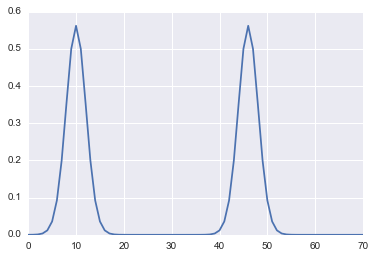

In [675]:
plt.plot(k[10].eval())

## A gaussian process prior on the weights with rbf kernel on theta = {1,...,38,...,2}...

In [586]:
from edward.util import rbf


# DATA
sess = ed.get_session()
# N is number of samples (ori x trials) and D is number of neurons
N, D = Xtrain_scaled.shape[0], Xtrain_scaled.shape[1]

########## MODEL ##########
X = tf.placeholder(tf.float32, [N, D])
cov = tf.nn.softplus(tf.random_normal([C-1,C-1]))

####### the X matrix should NOT be cov, but rather 1....72
length = tf.nn.softplus(tf.Variable(tf.random_normal([])))
var = tf.nn.softplus(tf.Variable(tf.random_normal([])))

kern = tf.cast(np.reshape(np.concatenate((np.arange(1,38), np.arange(start=36, stop=1, step=-1))), (-1,1)), tf.float32)

rbf_kernel = rbf(X = kern, lengthscale = length, variance = var)[:-1,:-1]

w = MultivariateNormalTriL(loc = tf.zeros([D,C-1]), 
                           scale_tril = rbf_kernel)

b = Normal(loc = tf.zeros(C-1), scale= tf.ones(C-1))
logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)
y = Categorical(logits = logits)

########## INFERENCE ##########
qw_loc = tf.Variable(tf.random_normal([D, C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, 
                    data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 3000)

init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%100 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()


########## EVAL ##########
qw_mod = tf.concat([qw.mean(), np.zeros((qw.shape[0],1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

{'t': 1, 'loss': 76139.453}
{'t': 101, 'loss': 9901.9434}
{'t': 201, 'loss': 7551.4932}
{'t': 301, 'loss': 7504.2817}
{'t': 401, 'loss': 6954.209}
{'t': 501, 'loss': 6527.4844}
{'t': 601, 'loss': 6183.5815}
{'t': 701, 'loss': 6848.6714}
{'t': 801, 'loss': 5904.2729}
{'t': 901, 'loss': 5854.874}
{'t': 1001, 'loss': 5869.7002}
{'t': 1101, 'loss': 5989.3584}
{'t': 1201, 'loss': 5507.9302}
{'t': 1301, 'loss': 5322.6533}
{'t': 1401, 'loss': 5546.4761}
{'t': 1501, 'loss': 5355.0688}
{'t': 1601, 'loss': 5312.4595}
{'t': 1701, 'loss': 5690.8154}
{'t': 1801, 'loss': 5421.7969}
{'t': 1901, 'loss': 5401.9678}
{'t': 2001, 'loss': 5315.6436}
{'t': 2101, 'loss': 5395.876}
{'t': 2201, 'loss': 5419.2461}
{'t': 2301, 'loss': 5362.2905}
{'t': 2401, 'loss': 5310.3989}
{'t': 2501, 'loss': 5249.7871}
{'t': 2601, 'loss': 5274.8633}
{'t': 2701, 'loss': 5128.0903}
{'t': 2801, 'loss': 5308.978}
{'t': 2901, 'loss': 5241.1362}
0.997869066249
[ 0.90925926  0.99537037  0.99814815  1.          1.          1.       

In [587]:
########## EVAL ##########
qw_mod = tf.concat([qw.mean(), np.zeros((qw.shape[0],1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(Xtest_scaled, tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))
print(evaluate_multiclass_model(x_test_scaled_3d, qw_mod.eval().T, qb_mod.eval()))

0.997869066249
[ 0.90925926  0.99537037  0.99814815  1.          1.          1.        ]


In [ ]:
plt.plot(w.eval()[0])

In [589]:
rbf_kernel.eval()

array([[ 0.49341494,  0.48366931,  0.45557225, ...,  0.35858503,
         0.41232386,  0.45557225],
       [ 0.48366931,  0.49341494,  0.48366931, ...,  0.41232386,
         0.45557225,  0.48366931],
       [ 0.45557225,  0.48366931,  0.49341494, ...,  0.45557222,
         0.48366931,  0.49341494],
       ..., 
       [ 0.35858503,  0.41232386,  0.45557222, ...,  0.49341494,
         0.48366931,  0.45557222],
       [ 0.41232386,  0.45557225,  0.48366931, ...,  0.48366931,
         0.49341494,  0.48366931],
       [ 0.45557225,  0.48366931,  0.49341494, ...,  0.45557222,
         0.48366931,  0.49341494]], dtype=float32)

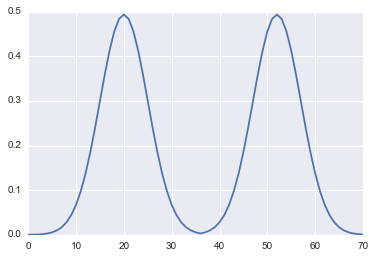

In [597]:
plt.plot(rbf_kernel.eval()[20])

In [254]:
length.eval(), var.eval()

(4.4581113, 0.50333989)

In [ ]:
plt.plot(w.eval()[10])

In [554]:
length.eval(), var.eval()

(4.4087973, 0.5023067)

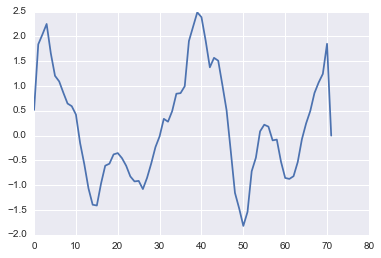

In [262]:
%matplotlib inline
plt.plot(qw_mod[0].eval())

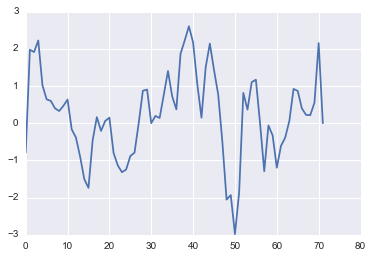

In [246]:
%matplotlib inline
plt.plot(qw_mod[0].eval())

## Experimental

In [ ]:
#### MODEL working VI for multi-class setting and converges quickly
C = 72
N = Xtrain_scaled.shape[0]
X = tf.placeholder(tf.float32, [N, D])
#w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), scale_tril = tf.cast(sample_cov[:-1,:-1], tf.float32))
w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), 
                           scale_tril = rbf(tf.cast(np.mean(x_train_scaled, axis=1), tf.float32))[:-1,:-1])

b = Normal(loc = tf.zeros(C-1), scale = 1 * tf.ones([]))

logits = tf.matmul(X, w) + b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)

y = Multinomial(logits = tf.nn.softmax(logits), total_count=1.0)

# INFERENCE
qw_loc = tf.Variable(tf.random_normal([D,C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain_hot})
inference.initialize(n_iter = 10000)

In [ ]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

In [ ]:
A = np.zeros((C-1,C))
for i in range(C-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .01 * np.identity(C) # A^T.dot(A) + .1 * I for invertability
lambda_1 = 1
precision = lambda_1 * precision
#precision = precision + 1 * np.identity(C) # add sparsity prior 
cov_matrix = tf.matrix_inverse(precision)
cov_matrix_chol = tf.cholesky(cov_matrix)

In [ ]:
A = np.zeros((D-1,D))
for i in range(D-1):
    A[i,i] = -1
    A[i,i+1] = 1
precision = A.T.dot(A) + .01 * np.identity(D) # A^T.dot(A) + .1 * I for invertability
lambda_1 = 1
precision = lambda_1 * precision
precision = precision + 1 * np.identity(D) # add sparsity prior 
cov_matrix = tf.matrix_inverse(precision)
cov_matrix_chol = tf.cholesky(cov_matrix)

In [ ]:
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]    

C = 72
N = Xtrain_scaled.shape[0]
X = tf.placeholder(tf.float32, [N, D])
#w = Normal(loc = tf.zeros((D,C-1)), scale = 1 * tf.ones((D,C-1)))
w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), 
                           scale_tril = tf.cast(tf.cholesky(cov_matrix[:-1,:-1]), tf.float32))

# define a (batch of D) C-1 multivariate normals
#w = MultivariateNormalFullCovariance(loc = tf.zeros((D,C-1)),
#                                     covariance_matrix = tf.cast(cov_matrix[:-1,:-1], tf.float32))

#w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)),
#                                     scale_tril = tf.cast(cov_matrix_chol[:-1,:-1], tf.float32))

#w = MultivariateNormalTriL(loc = tf.zeros((D,C-1)), scale_tril = rbf_kernel)
#w = Normal(loc = tf.zeros((D,C-1)), scale = 1* tf.ones(C-1))
#b = Normal(loc = tf.zeros(C-1, 1), scale = 1 * tf.ones([]))

logits = tf.matmul(X, (w)) #+ b
logits = tf.concat([logits, np.zeros((N, 1))], axis = 1)

y = Categorical(probs = tf.nn.softmax(logits))


# INFERENCE
qw_loc = tf.Variable(tf.random_normal([D,C-1]))
#qb_loc = tf.Variable(tf.zeros([C-1]))

qw = PointMass(params = qw_loc)
#qb = PointMass(params = qb_loc)

inference = ed.MAP({w: qw}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 5000)

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
inference.finalize()

In [ ]:

'''
qw_loc = tf.Variable(tf.random_normal([D,C-1]))
qw_scale = tf.nn.softplus(tf.Variable(tf.random_normal([D,C-1])))

qb_loc = tf.Variable(tf.random_normal([C-1]))
qb_scale = tf.nn.softplus(tf.Variable(tf.random_normal([])))

qw = Normal(loc = qw_loc, scale = qw_scale)
qb = Normal(loc = qb_loc, scale = qb_scale)

inference = ed.KLqp({w: qw, b: qb}, data={X: Xtrain_scaled, y: Ytrain})
inference.initialize(n_iter = 10000)
'''
'''
# EVALUATION ON TEST DATA
qw_mod = tf.concat([tf.transpose(qw.mean()), np.zeros((58,1))], axis=1)
qb_mod = tf.concat([qb.mean(), np.zeros((1))], axis=0)
logits = tf.matmul(tf.cast(sklearn.preprocessing.scale(Xtest), tf.float32), qw_mod) + qb_mod
print(compute_average_auc(tf.nn.softmax(logits).eval(), Ytest_hot))

print(evaluate_multiclass_model(x_test_scaled, qw_mod.eval(), qb_mod.eval()))
'''

# STAN

In [ ]:
import pystan

In [ ]:
Ytrain=Ytrain+1

In [ ]:
### MAP estimation with beta ~ normal(0,1)

# K outcomes
multi_logit_code = """
data {
    int<lower=2> K; // num orientations
    int<lower=0> N; // num samples
    int<lower=1> D; // num features
    int y[N];
    vector[D] x[N];
}
parameters {
    matrix[K,D] beta;
    vector[K] intercept;
}
model {
    for (k in 1:K) {
        beta[k] ~ normal(0,1);
    }
    //for (d in 1:D) {
    //    beta[:,d] ~ normal(0,1);
    //}
    intercept ~ normal(0,1);
    for (n in 1:N) {
       y[n] ~ categorical_logit(beta * x[n] + intercept);
    }
}
"""
dat = {'K': 72, 'N': 2520, 'D': 58, 'x': Xtrain_scaled, 'y': Ytrain}

sm = pystan.StanModel(model_code = multi_logit_code)
fit = sm.optimizing(data= dat);

In [ ]:
beta_ori = fit['beta']
intercept_ori = fit['intercept']

In [ ]:
evaluate_multiclass_model(x_test_scaled_3d, beta_ori, intercept_ori)

In [ ]:
### MAP estimation with beta ~ normal(0,1)

# K outcomes
multi_logit_code = """
data {
    int<lower=2> K; // num orientations
    int<lower=0> N; // num samples
    int<lower=1> D; // num neurons
    int y[N];
    vector[D] x[N];
}
transformed data {
    row_vector[D] zeros;
    zeros = rep_row_vector(0, D);
}
parameters {
    matrix[K-1, D] beta_raw;
    vector[K] intercept;
    real<lower=0> sigma[K];
    real<lower=0> sigma_intercept;
}
transformed parameters {
    matrix[K, D] beta;
    beta = append_row(beta_raw, zeros);
}
model {
    for (k in 1:K) {
        beta[k] ~ normal(0,sigma[k]);
    }
    //for (d in 1:D) {
    //    beta[:,d] ~ normal(0,1);
    //}
    intercept ~ normal(0,sigma_intercept);
    for (n in 1:N) {
       y[n] ~ categorical_logit(beta * x[n] + intercept);
    }
}
"""
dat = {'K': 72, 'N': 2520, 'D': 58, 'x': Xtrain, 'y': Ytrain}

sm = pystan.StanModel(model_code = multi_logit_code)
fit = sm.vb(data= dat)

In [ ]:
# gaussian process prior
multi_logit_code = """
data {
    int<lower=2> K;
    int<lower=0> N;
    int<lower=1> D;
    int y[N];
    vector[D] x[N];
}
transformed data {
    //cov_matrix[K] Kern;
    //K = cov_exp_quad()
    
}
parameters {
    matrix[K,D] beta;
    vector[K] intercept;
    //cov_matrix[K] Kern;
    //K = cov_exp_quad(beta, 1 1);
}
model {
    for (d in 1:D) {
        beta[:,d] ~ multi_normal(0, Kern);
    }
    // beta[:,d] ~ GP[0, squared rbf kernel] model each column as a gp 
    intercept ~ normal(0,1);
    for (n in 1:N) {
       y[n] ~ categorical_logit(beta * x[n] + intercept);
    }
}
"""
dat = {'K': 4, 'N': 140, 'D': 58, 'x': Xtrain_n, 'y': yt}

sm = pystan.StanModel(model_code = multi_logit_code)
fit = sm.vb(data= dat);